# compute_dndt
This notebook computes the detection rate $\frac{dN}{dt}$, views how its value depends on solar position vector $\vec{k}$, and how its value depends on the maximum allowable value of (h,k,l)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as unit
import astropy.constants as const
import itertools
import pandas as pd

from axion_functions import *

In [2]:
#Define constants
a = 6.642 #Lattice constant, Angstroms = 1e-10m, from Dent paper. 
hbar_kevs = (const.hbar.to(unit.keV*unit.s)).value #hbar, keV*s, from astropy
c_aas = (const.c.to(unit.AA/unit.s)).value #speed of light, angstrom/s (cancels with a), from astropy

mass = 50*unit.kg
vol = ((mass/(3.67*unit.g*(unit.cm)**(-3))).to(unit.AA**3)).value #Crystal volume, in AA^3

vol_cell = 67.71 #In AA^3, from Dent paper

s_in_y = 365.25*24*60*60 #Number of seconds in a year

compute_dndt returns the value:
$$\frac{dN}{dt} = \pi g_{a\gamma}^2 (\hbar c)^3 \frac{V}{V_{cell}^2}\sum_{\vec{G}} \frac{d\Phi_a}{dE_a} \frac{|F(\vec{G}) S(\vec{G})|^2}{|\vec{G}|^2} \sin^2\left[2\theta(\vec{k},\vec{G})\right] \mathcal{W}\left(E_a(\vec{G}),\Delta \right)$$
The parameter max_hkl truncates the sum over $\vec{G}$ to those below a set maximum of h, k, or l (see math notes). This sum is safe to truncate since higher $|\vec{G}|$ creates higher energy inside the sum, which has a lower flux value $\frac{d\Phi_a}{dE_a}$ and won't be detected in the energy range set by $\mathcal{W}$. It also isn't too hard to directly test what changing max_hkl does to the event rate. Dent et.al truncates this sum at max_hkl=5, so that is the default here.

**Running compute_dndt will often result in division-by-zero warnings, but this is expected and accounted for.** These happen since $E_a \propto \frac{1}{\vec{k} \cdot \vec{G}}$ which may diverge, but any energies too high end up going to zero in the sum thanks to $\mathcal{W}$

In [7]:
def compute_dndt(max_hkl = 5, k=[1,0,0], coupling=2e-10, time=3, m_a=0.01, return_rate = False, return_energy = False):
    '''Returns either the event rate in s^-1 (if return_rate is true) or the total expected events assuming
    constant event rate for the input time in years.

    Coupling is in GeV^-1, time is in years, m_a is in keV'''
    hkl = np.array(make_hkl_double(max_h = max_hkl, 
                                  max_k = max_hkl,
                                  max_l = max_hkl))
    g_ag = coupling
    g_arr = (2*np.pi/a)*hkl #G vectors, in AA^(-1)
    mod2_g = mod2(g_arr) #Magnitude square of G vectors, 
    FAq_Na = FA_qv2(mod2_g, Z=11)
    FAq_I  = FA_qv2(mod2_g, Z=53)
    ginv_array = 1/mod2_g
    ginv_replicant = np.stack((ginv_array, ginv_array,ginv_array), axis=1)
    ghat = g_arr*np.sqrt(ginv_replicant)
    gk = np.abs(gdotk_cart(hkl_to_cart(ghat), k/cart_mag(np.array(k))))
    sin2 = 4*gk**2*(1-gk**2) #sin^2(2\theta)

    summand = ((FAq_Na+FAq_I)**2)*ginv_array*sin2*64 #*4 from S, *4 from form factor F

    E_arr = hbar_kevs*c_aas*np.sqrt(mod2_g)/(2*gk) #in keV 
    #The infinities here are fine; they go to zero in the W function
    W = w_func(E_arr, E1=1, E2=50, dVector=True, Delta = make_delta(E_arr)) #Delta from Simulation of BG report
    dphi_de = primakoff_flux(E_arr, coupling=g_ag, m_a = m_a) + coalescence_flux(E_arr, coupling=g_ag, m_a = m_a)

    final_summand = W*dphi_de*1e-16*summand #1e-16 to cancel angstroms and cm squared

    nt_constant = np.pi*(g_ag*1e-6)**2*(hbar_kevs*c_aas)**3*vol/(vol_cell**2) #in keV
    if return_energy:
        dct = {"G"   : mod2_g,
               "sin2": sin2,
               "E"   : E_arr,
               "Rate": nt_constant*final_summand
               }
        return pd.DataFrame(dct)
    else:
        final_dndt = nt_constant*np.sum(final_summand) #in s^(-1), 1e-16 converts angstroms and cm
        if return_rate:
            return final_dndt
        return final_dndt*s_in_y*time

We can check how safe it is to truncate the $\vec{G}$ sum directly:

In [37]:
def hkl_dependence(max_hkl):
    hkl_dndt = lambda hkl: compute_dndt(max_hkl = hkl, return_rate=True)
    hkls = np.arange(1, max_hkl, 1)
    dndts = my_map(hkl_dndt, hkls)
    return np.vstack((hkls, dndts)).transpose()

C:\Users\taase\AppData\Local\Temp\ipykernel_4324\4070832194.py:23: RuntimeWarning: divide by zero encountered in divide
  E_arr = hbar_kevs*c_aas*np.sqrt(mod2_g)/(2*gk) #in keV
c:\Users\taase\OneDrive\Documents\School\Unimelb\Winter Project\Axion-Flux\Clean\axion_functions.py:120: RuntimeWarning: overflow encountered in exp
  val = np.sqrt(lmda)*phi_e0*E*(E**2 - m_a**2)/(np.exp(E/1.1) - 0.7)*(1+0.02*m_a)


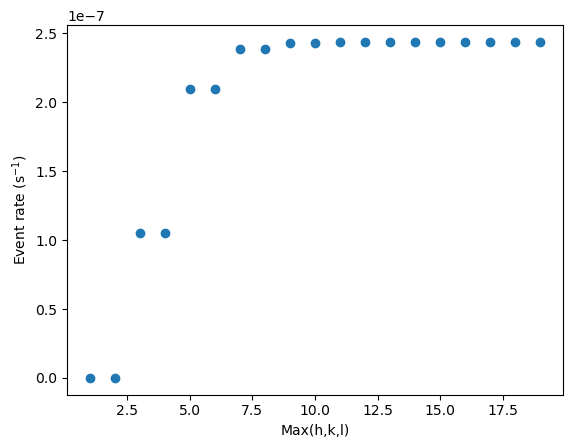

In [42]:
plt.scatter(hkl_dependence(20)[:,0], hkl_dependence(20)[:,1])
plt.ylabel("Event rate (s$^{-1}$)")
plt.xlabel("Max(h,k,l)")
plt.show()

Note that the structure factor condition that h,k,l are all even means that $\max(h,k,l)=2n$ is the same as $\max(h,k,l)=2n+1$ for integers n

$\frac{dN}{dt}$ depends on the solar position $\vec{k}$. This vector can be written as a unit vector in spherical coordinates to analyse what happens as $\vec{k}$ changes.

In [13]:
phi_axis =  np.arange(0, 2*np.pi, 0.05)
theta_axis = np.arange(0,np.pi,   0.05)
angle_plane = np.array(list(itertools.product(phi_axis, theta_axis)))

def angle_dependence(g_ag = 2e-10, t=3, mass = 0.01):
    outputs = []
    for angles in angle_plane:
        phi = angles[0]
        theta = angles[1]
        k_vec = [np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)]
        outputs.append(compute_dndt(k = k_vec, coupling = g_ag, time=t, m_a = mass))
    return np.array(outputs)

rates_on_angle = angle_dependence(g_ag = 1e-10, t=3, mass = 0.01)
rates_square = np.reshape(rates_on_angle, (len(phi_axis), len(theta_axis)))

C:\Users\taase\AppData\Local\Temp\ipykernel_4324\4070832194.py:23: RuntimeWarning: divide by zero encountered in divide
  E_arr = hbar_kevs*c_aas*np.sqrt(mod2_g)/(2*gk) #in keV


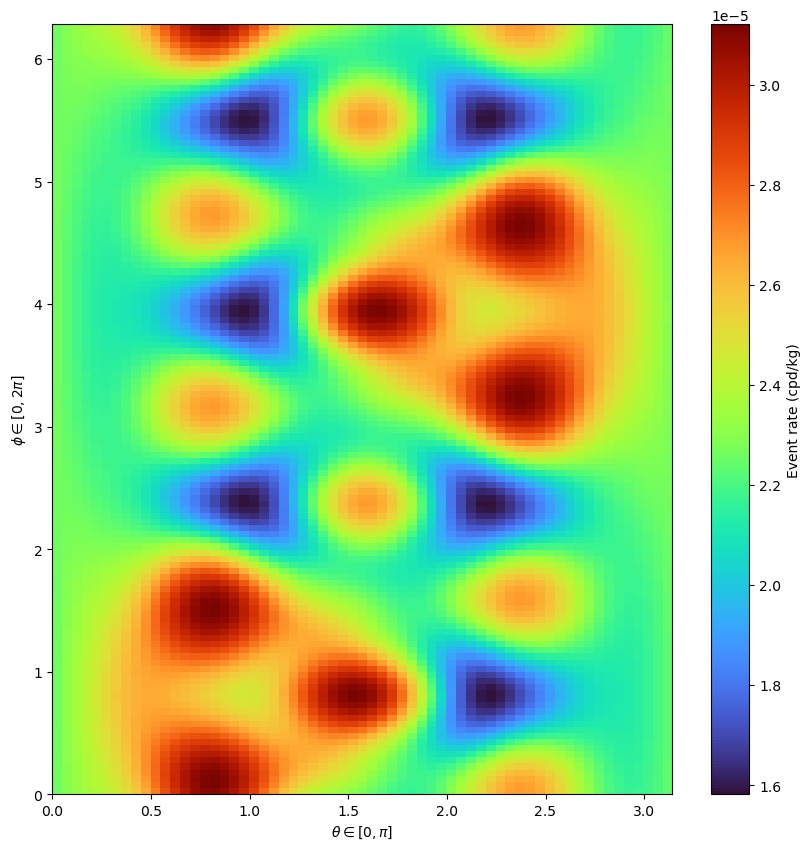

In [14]:
fig,ax = plt.subplots(figsize=(10,10))
cpd = rates_square/(3*s_in_y)*86400/50
image = ax.imshow(cpd, interpolation='none', extent = (0,np.pi,0,2*np.pi), aspect='auto', origin='lower', cmap='turbo')
#path = ax.plot(theta_phi(phi_axis), phi_axis, c="white")
#ax.scatter(alt_polar, az_rad, c="magenta")

ax.set_xlim([0, np.pi])

cbar = plt.colorbar(image)
cbar.set_label("Event rate (cpd/kg)")
plt.xlabel("$\\theta \in [0,\pi]$")
plt.ylabel("$\phi \in [0,2\pi]$")
plt.show()